<a href="https://colab.research.google.com/github/KESAVE8604-droid/kesaverdhen-hybrid-movie-recommender/blob/main/notebooks/Phase4_HybridFusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Phase 4 — Hybrid Fusion Layer**

🌐 Goal

To combine the predictions of your Collaborative Filtering (CF) and Content-Based models into a single hybrid score for improved recommendation accuracy.

🧩 Approach 1: Weighted Average Fusion

We’ll implement the weighted hybrid equation:

HybridScore
=
𝛼
×
𝐶
𝐹
_
𝑆
𝑐
𝑜
𝑟
𝑒
+
(
1
−
𝛼
)
×
𝐶
𝑜
𝑛
𝑡
𝑒
𝑛
𝑡
_
𝑆
𝑐
𝑜
𝑟
𝑒
HybridScore=α×CF_Score+(1−α)×Content_Score

Where:

CF_Score → Predicted rating from the collaborative model

Content_Score → Similarity-based score from the TF-IDF model

α (alpha) → Tunable weight (default: 0.7

In [21]:
!pip install numpy==1.26.4 --quiet
import numpy as np
print("✅ NumPy version:", np.__version__)


✅ NumPy version: 2.3.4


In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math

# Paths
base_path = "/content/drive/MyDrive/MovieRecommender"
clean_path = os.path.join(base_path, "movielens_cleaned.csv")

# Load cleaned dataset
movies_df = pd.read_csv(clean_path)
print("✅ Loaded dataset:", movies_df.shape)

# Extract unique movies
movies_unique = movies_df[['MovieID', 'Clean_Title', 'Genres', 'Year']].drop_duplicates().reset_index(drop=True)
print("🎥 Unique movies:", movies_unique.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded dataset: (1000209, 12)
🎥 Unique movies: (3706, 4)


In [2]:
# Rebuild TF-IDF and cosine similarity fresh
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import pandas as pd

# Load cleaned dataset
movies_df = pd.read_csv("/content/drive/MyDrive/MovieRecommender/movielens_cleaned.csv")

# Keep unique movies
movies_unique = movies_df[['MovieID', 'Clean_Title', 'Genres', 'Year']].drop_duplicates().reset_index(drop=True)

# Build metadata column
movies_unique['Genres'] = movies_unique['Genres'].astype(str)
movies_unique['Year'] = movies_unique['Year'].fillna('').astype(str)
movies_unique['Metadata'] = (
    movies_unique['Clean_Title'].astype(str) + " " +
    movies_unique['Genres'] + " " +
    movies_unique['Year']
).str.replace('[^a-zA-Z0-9 ]', ' ', regex=True).str.lower()

# TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(movies_unique['Metadata'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Save new versions (compatible with NumPy 2.x)
base_path = "/content/drive/MyDrive/MovieRecommender"
joblib.dump(tfidf, os.path.join(base_path, "tfidf_vectorizer.pkl"))
joblib.dump(tfidf_matrix, os.path.join(base_path, "tfidf_matrix.pkl"))
joblib.dump(cosine_sim, os.path.join(base_path, "cosine_similarity.pkl"))

print("✅ Rebuilt and saved TF-IDF + cosine similarity (NumPy 2.x compatible)")


✅ Rebuilt and saved TF-IDF + cosine similarity (NumPy 2.x compatible)


In [3]:
# Load saved models from Drive
tfidf = joblib.load(os.path.join(base_path, "tfidf_vectorizer.pkl"))
tfidf_matrix = joblib.load(os.path.join(base_path, "tfidf_matrix.pkl"))
cosine_sim = joblib.load(os.path.join(base_path, "cosine_similarity.pkl"))
cf_model = joblib.load(os.path.join(base_path, "collab_model.pkl"))

print("✅ Loaded TF-IDF, Cosine Similarity, and CF (SVD) model successfully.")


✅ Loaded TF-IDF, Cosine Similarity, and CF (SVD) model successfully.


In [4]:
# Index mapping for movie titles
indices = pd.Series(movies_unique.index, index=movies_unique['Clean_Title'].str.lower()).drop_duplicates()

def hybrid_recommend(user_id, liked_movie, alpha=0.7, top_n=10):
    liked_movie = liked_movie.lower().strip()
    if liked_movie not in indices:
        print("❌ Movie not found in dataset.")
        return pd.DataFrame()

    # Get movie index
    idx = indices[liked_movie]

    # Content similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_indices = [i[0] for i in sim_scores[1:200]]  # Top 200 similar movies

    # Compute hybrid score
    results = []
    for i in top_indices:
        movie_id = movies_unique.iloc[i]['MovieID']
        title = movies_unique.iloc[i]['Clean_Title']
        content_score = sim_scores[i][1]

        # Predict CF score
        cf_pred = cf_model.predict(user_id, movie_id).est
        cf_norm = (cf_pred - 1) / 4  # normalize 1–5 → 0–1

        # Weighted hybrid
        hybrid_score = alpha * cf_norm + (1 - alpha) * content_score
        results.append((title, movie_id, content_score, cf_pred, hybrid_score))

    df = pd.DataFrame(results, columns=['Title', 'MovieID', 'ContentScore', 'CF_Pred', 'HybridScore'])
    df = df.sort_values(by='HybridScore', ascending=False).head(top_n).reset_index(drop=True)
    return df


In [5]:
# Example test
user_id = 1
liked_movie = "Toy Story"

recommendations = hybrid_recommend(user_id, liked_movie, alpha=0.7, top_n=10)
print(f"🎥 Top Hybrid Recommendations for User {user_id} who liked '{liked_movie}':")
recommendations


🎥 Top Hybrid Recommendations for User 1 who liked 'Toy Story':


,Title,MovieID,ContentScore,CF_Pred,HybridScore
0,Toy Story 2,3114,0.142242,4.729022,0.695251
1,"Christmas Story, A",2804,0.339563,4.330173,0.684649
2,Babe,34,0.012720,4.520972,0.619986
3,"Philadelphia Story, The",898,0.010151,4.486990,0.613269
4,"Palm Beach Story, The",2937,0.007669,4.429154,0.602403
5,West Side Story,1947,0.011731,4.366290,0.592620
6,"Soldier's Story, A",2852,0.132502,4.133243,0.588068
7,Seven (Se7en),47,0.099623,4.181030,0.586567
8,"Little Princess, A",262,0.009655,4.299094,0.580238
9,Braveheart,110,0.132502,4.085561,0.579724


In [6]:
# Build training data
sample_df = movies_df.sample(10000, random_state=42)  # sample for quick training
X = []
y = []

for _, row in sample_df.iterrows():
    user = row['UserID']
    movie = row['MovieID']
    rating = row['Rating']

    # CF prediction
    cf_est = cf_model.predict(user, movie).est
    cf_norm = (cf_est - 1) / 4

    # Content similarity (mean similarity to the movie itself)
    if movie in movies_unique['MovieID'].values:
        idx = movies_unique[movies_unique['MovieID'] == movie].index[0]
        cont_score = np.mean(cosine_sim[idx])
    else:
        cont_score = 0

    X.append([cf_norm, cont_score])
    y.append(rating)

X = np.array(X)
y = np.array(y)

# Train Gradient Boosting Regressor
meta_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
meta_model.fit(X_train, y_train)

# Evaluate
y_pred = meta_model.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"✅ Meta-Learner RMSE: {rmse:.4f}")

# Save model
joblib.dump(meta_model, os.path.join(base_path, "hybrid_meta_model.pkl"))
print("💾 Meta-learner saved as hybrid_meta_model.pkl")


✅ Meta-Learner RMSE: 0.7313
💾 Meta-learner saved as hybrid_meta_model.pkl


In [7]:
def hybrid_meta_predict(user_id, liked_movie, top_n=10):
    liked_movie = liked_movie.lower().strip()
    if liked_movie not in indices:
        print("❌ Movie not found.")
        return pd.DataFrame()

    idx = indices[liked_movie]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_indices = [i[0] for i in sim_scores[1:200]]

    rows = []
    for i in top_indices:
        movie_id = movies_unique.iloc[i]['MovieID']
        title = movies_unique.iloc[i]['Clean_Title']
        content_score = sim_scores[i][1]

        cf_pred = cf_model.predict(user_id, movie_id).est
        cf_norm = (cf_pred - 1) / 4

        # Meta-learner prediction
        pred_rating = meta_model.predict([[cf_norm, content_score]])[0]
        rows.append((title, movie_id, content_score, cf_pred, pred_rating))

    df = pd.DataFrame(rows, columns=['Title', 'MovieID', 'ContentScore', 'CF_Pred', 'Meta_Pred'])
    df = df.sort_values(by='Meta_Pred', ascending=False).head(top_n).reset_index(drop=True)
    return df


In [8]:
meta_recs = hybrid_meta_predict(1, "Toy Story", top_n=10)
print("🎬 Meta-Learner Hybrid Recommendations:")
meta_recs


🎬 Meta-Learner Hybrid Recommendations:


,Title,MovieID,ContentScore,CF_Pred,Meta_Pred
0,Babe,34,0.012720,4.520972,4.676463
1,"Philadelphia Story, The",898,0.010151,4.486990,4.658349
2,West Side Story,1947,0.011731,4.366290,4.555850
3,"Little Princess, A",262,0.009655,4.299094,4.545023
4,"Palm Beach Story, The",2937,0.007669,4.429154,4.543765
5,Toy Story 2,3114,0.142242,4.729022,4.438996
6,Underground,665,0.007540,4.259192,4.378730
7,Dead Man Walking,36,0.012699,4.251008,4.283613
8,"American President, The",11,0.009229,4.148297,4.283188
9,"NeverEnding Story, The",2161,0.010240,4.250125,4.248336


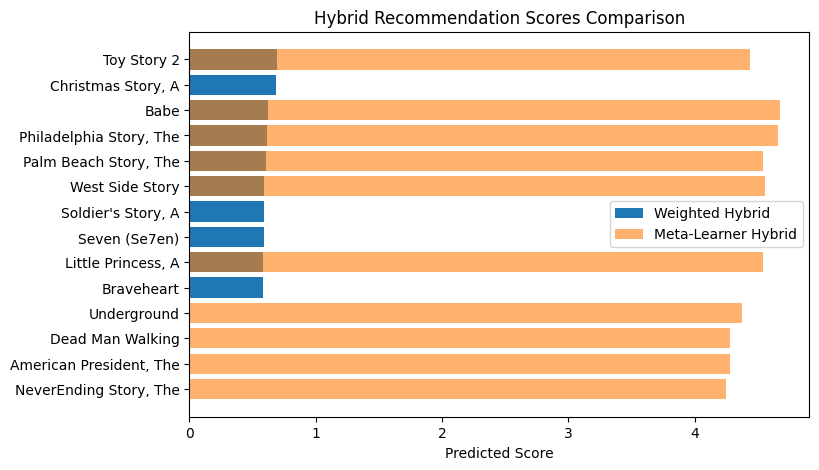

✅ Final Hybrid Model Saved to Drive!


In [9]:
# Compare Weighted vs Meta results visually
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.barh(recommendations['Title'], recommendations['HybridScore'], label='Weighted Hybrid')
plt.barh(meta_recs['Title'], meta_recs['Meta_Pred'], alpha=0.6, label='Meta-Learner Hybrid')
plt.legend()
plt.title("Hybrid Recommendation Scores Comparison")
plt.xlabel("Predicted Score")
plt.gca().invert_yaxis()
plt.show()

# Save Hybrid Model
joblib.dump({
    'tfidf': tfidf,
    'cosine_sim': cosine_sim,
    'cf_model': cf_model,
    'meta_model': meta_model,
    'movies_unique': movies_unique
}, os.path.join(base_path, "final_hybrid_model.pkl"))

print("✅ Final Hybrid Model Saved to Drive!")
